In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

In [2]:
data = pd.read_csv( r"C:dataset_sdn.csv")

In [3]:
data

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [4]:
data.shape

(104345, 23)

In [5]:
class Model:
    global y
    
    def __init__(self, X_train, y_train, X_eval_data, y_eval):
        scaler = preprocessing.StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.y_train = y_train
        self.X_test = scaler.transform(X_eval_data)
        self.y_test = y_eval 
        
        self.accuracy_lr = 0
        self.accuracy_svm = 0
        self.accuracy_rf = 0
        self.accuracy_gbc = 0

    def LogisticRegression(self):
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

        start_time = time.time()
        results_lr = []
        accuracy_list = []
        for solver in solvers:
            LR = LogisticRegression(C=0.03, solver=solver).fit(self.X_train, self.y_train)
            predicted_lr = LR.predict(self.X_test)
            accuracy_lr = accuracy_score(self.y_test, predicted_lr)
            
            results_lr.append({'solver': solver, 'accuracy': f"{round(accuracy_lr * 100, 2)}%",
                               'Coefficients': {'W': LR.coef_, 'b': LR.intercept_}})
            
            accuracy_list.append(accuracy_lr)
       
        solver_name = solvers[accuracy_list.index(max(accuracy_list))]
        LR = LogisticRegression(C=0.03, solver=solver_name).fit(self.X_train, self.y_train)
        predicted_lr = LR.predict(self.X_test)
        accuracy_lr = accuracy_score(self.y_test, predicted_lr)
        print(f"Accuracy of LR model is: {round(accuracy_lr * 100, 2)}%", '\n')
        print("########################################################################")
        print('Best solver is:', solver_name)
        print("########################################################################")
        print(classification_report(predicted_lr, self.y_test), '\n')
        print("########################################################################")
        print("--- %s seconds --- time for LogisticRegression" % (time.time() - start_time))
        self.accuracy_lr = accuracy_lr

        cm = confusion_matrix(self.y_test, predicted_lr)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - Logistic Regression ({solver_name})')
        plt.show()
        
    def SupportVectorMachine(self):
        start_time = time.time()
        accuracy_list = []
        result_svm = []
        kernels = ['linear', 'poly', 'rbf', 'sigmoid']

        for kernel in kernels:
            SVM = svm.SVC(kernel=kernel).fit(self.X_train, self.y_train)
            predicted_svm = SVM.predict(self.X_test)
            accuracy_svm = accuracy_score(self.y_test, predicted_svm)
            result_svm.append({"kernel": kernel, "accuracy": f"{round(accuracy_svm * 100, 2)}%"})
            print("Accuracy: %.2f%%" % round((accuracy_svm * 100.0), 2))
            print('######################################################################')
            accuracy_list.append(accuracy_svm)

        kernel_name = kernels[accuracy_list.index(max(accuracy_list))]
        SVM = svm.SVC(kernel=kernel_name).fit(self.X_train, self.y_train)
        predicted_svm = SVM.predict(self.X_test)
        accuracy_svm = accuracy_score(self.y_test, predicted_svm)
        print(f"Accuracy of SVM model {round(accuracy_svm, 2) * 100}%", '\n')
        print("########################################################################")
        print('Best kernel is:', kernel_name)
        print("########################################################################")
        print(classification_report(predicted_svm, self.y_test))
        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))
        self.accuracy_svm = accuracy_svm 

        cm = confusion_matrix(self.y_test, predicted_svm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - SVM ({kernel_name})')
        plt.show()
        
    def RandomForest(self):
        start_time = time.time()
    
        param_grid = {
    'n_estimators': [100, 200, 500],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 3, 4, 5, 6]  # Include 'None' for unlimited depth
}


        rf_base = RandomForestClassifier(criterion='gini', 
                                      oob_score=True,
                                      random_state=1,
                                      n_jobs=-1)

        rf_search = GridSearchCV(rf_base, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
        rf_search.fit(self.X_train, self.y_train)
    
        best_rf = rf_search.best_estimator_
        predicted_rf = best_rf.predict(self.X_test)
        accuracy_rf = accuracy_score(self.y_test, predicted_rf)

        print(f"Accuracy of RF model is: {round(accuracy_rf * 100, 2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_rf, self.y_test))
        print("########################################################################")

        print("--- %s seconds ---" % (time.time() - start_time))
        self.accuracy_rf = accuracy_rf

        cm = confusion_matrix(self.y_test, predicted_rf)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Random Forest')
        plt.show()
        
    def GradientBoost(self):
        start_time = time.time()
        gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
        gbc.fit(self.X_train, self.y_train)

        predicted_gbc = gbc.predict(self.X_test)
        accuracy_gbc = accuracy_score(self.y_test, predicted_gbc)
        print(f"Accuracy of Gradient Boosting model is: {round(accuracy_gbc * 100, 2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_gbc, self.y_test))
        print("########################################################################")

        print("--- %s seconds ---" % (time.time() - start_time))
        self.accuracy_gbc = accuracy_gbc


        cm = confusion_matrix(self.y_test, predicted_gbc)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Gradient Boosting')
        plt.show()

        
    def plot_accuracy(self, accuracies, model_names):
        plt.figure(figsize=(10, 6))
        plt.bar(model_names, accuracies, color='blue')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.title('Accuracy of Different Models')
        plt.ylim(0, 100)  # Set y-axis limit to be between 0 and 100 (percentage)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def run_models(self):
        self.LogisticRegression()
        self.SupportVectorMachine()
        self.RandomForest()
        self.GradientBoost()

        model_names = ['Logistic Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting']
        accuracies = [self.accuracy_lr * 100, self.accuracy_svm * 100, self.accuracy_rf * 100, self.accuracy_gbc * 100]

        self.plot_accuracy(accuracies, model_names)


In [6]:
df = data.copy()
df = df.dropna()

In [7]:

X_eval_data = df.drop(['dt','src','dst','label','Protocol', 'switch', 'pktcount', 'dur_nsec', 'tot_dur', 'flows', 'port_no','tx_kbps', 'rx_kbps'], axis=1)
y_eval = df.label

In [8]:
X_eval_data.head()

,bytecount,dur,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tot_kbps
0,48294064,100,1943,13535,14428310,451,0,143928631,3917,0.0
1,134737070,280,1943,13531,14424046,451,0,3842,3520,0.0
2,96294978,200,1943,13534,14427244,451,0,3795,1242,0.0
3,96294978,200,1943,13534,14427244,451,0,3688,1492,0.0
4,96294978,200,1943,13534,14427244,451,0,3413,3665,0.0


In [9]:
X_eval_data.shape

(103839, 10)

In [10]:
y_eval.shape

(103839,)

In [11]:
data= pd.read_csv(r"C:\Users\alexm\TFG_09_05\balanced_dataset_total.csv", sep=',', low_memory=False)
data.shape

(102056, 90)

In [12]:
data['bytecount'] = data['Total Length of Fwd Packets'] + data[' Total Length of Bwd Packets']
data['packetins'] = data[' Total Fwd Packets'] + data[' Total Backward Packets']
data.shape

(102056, 92)

In [13]:
data[' Packet Length Mean'] = pd.to_numeric(data[' Packet Length Mean'], errors='coerce')
data['Flow Bytes/s'] = pd.to_numeric(data['Flow Bytes/s'], errors='coerce')
data[' Flow Packets/s'] = pd.to_numeric(data[' Flow Packets/s'], errors='coerce')
data[' Average Packet Size'] = pd.to_numeric(data[' Average Packet Size'], errors='coerce')

In [14]:
balanced_data = data

In [15]:
balanced_data_df = balanced_data.copy()
balanced_data_df = balanced_data_df.dropna()


In [16]:
balanced_data_df = balanced_data_df.replace([np.inf, -np.inf], np.nan)  # Reemplazar infinitos con NaN
balanced_data_df = balanced_data_df.dropna() 
balanced_data_df = balanced_data_df.rename(columns={
    ' Flow Duration': 'dur',
    ' Packet Length Mean': 'pktperflow',
    ' Average Packet Size': 'byteperflow',
    ' Flow Packets/s': 'pktrate',
    'Total Length of Fwd Packets': 'tx_bytes',
    ' Total Length of Bwd Packets': 'rx_bytes',
    'Flow Bytes/s': 'tot_kbps',
    'pairflow': 'Pairflow'
})
columns_to_keep = ['bytecount','dur','packetins','pktperflow','byteperflow','pktrate','Pairflow','tx_bytes','rx_bytes','tot_kbps']
#columns_to_keep = [' Flow Duration',' Total Fwd Packets',' Total Backward Packets','Total Length of Fwd Packets',' Total Length of Bwd Packets',' Fwd Packet Length Mean',' Bwd Packet Length Mean',' Packet Length Mean',' Average Packet Size','Flow Bytes/s',' Flow Packets/s','Fwd Packets/s',' Bwd Packets/s']
X_train_data  = balanced_data_df.filter(items=columns_to_keep)
#X = balanced_data_df.replace([np.inf, -np.inf], np.nan)  # Reemplazar infinitos con NaN
#X = X.dropna() 
y_train  = balanced_data_df.etiqueta

In [17]:
X_train_data .head()

,bytecount,dur,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tot_kbps
0,278.0,20697,4,63.4,79.25,1.932647e+02,1,78.0,200.0,1.343190e+04
1,864.0,1,2,432.0,648.00,2.000000e+06,0,864.0,0.0,8.640000e+08
2,160.0,20585,4,38.4,48.00,1.943162e+02,1,64.0,96.0,7.772650e+03
3,1136.0,1,2,568.0,852.00,2.000000e+06,0,1136.0,0.0,1.136000e+09
4,1192.0,1,2,596.0,894.00,2.000000e+06,0,1192.0,0.0,1.192000e+09


In [18]:
X_train_data .shape

(99286, 10)

In [19]:
y_train.shape

(99286,)

In [20]:
X_train_data = pd.get_dummies(X_train_data)

In [21]:
X_eval_data = pd.get_dummies(X_eval_data)

In [22]:
M = Model(X_train_data, y_train, X_eval_data, y_eval)

In [23]:
#M.LogisticRegression()

In [24]:
#M.SupportVectorMachine()

In [25]:
#M.RandomForest()

In [26]:
#M.GradientBoost()

C:\Users\alexm\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\alexm\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\alexm\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy of LR model is: 56.04% 

########################################################################
Best solver is: saga
########################################################################
              precision    recall  f1-score   support

           0       0.84      0.60      0.70     89110
           1       0.12      0.33      0.17     14729

    accuracy                           0.56    103839
   macro avg       0.48      0.46      0.44    103839
weighted avg       0.74      0.56      0.63    103839
 

########################################################################
--- 7.822142124176025 seconds --- time for LogisticRegression


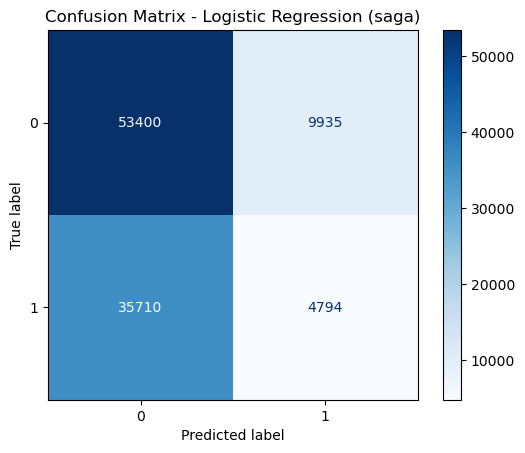

Accuracy: 50.83%
######################################################################
Accuracy: 38.97%
######################################################################
Accuracy: 39.01%
######################################################################
Accuracy: 47.58%
######################################################################
Accuracy of SVM model 51.0% 

########################################################################
Best kernel is: linear
########################################################################
              precision    recall  f1-score   support

           0       0.69      0.58      0.63     75718
           1       0.22      0.31      0.26     28121

    accuracy                           0.51    103839
   macro avg       0.46      0.45      0.44    103839
weighted avg       0.57      0.51      0.53    103839

########################################################################
--- 495.144766330719 seconds ---


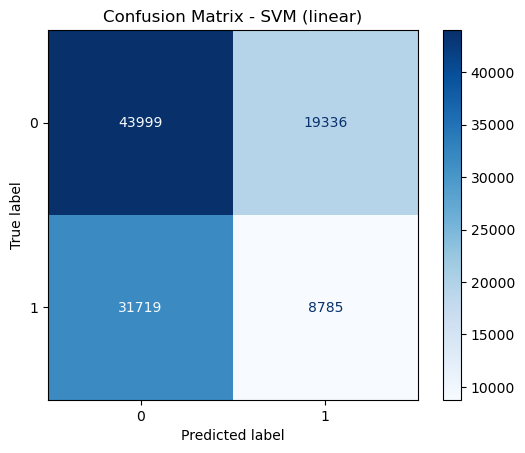

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Accuracy of RF model is: 39.01% 

########################################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.39      0.56    103839

    accuracy                           0.39    103839
   macro avg       0.50      0.20      0.28    103839
weighted avg       1.00      0.39      0.56    103839

########################################################################
--- 1128.3047184944153 seconds ---


C:\Users\alexm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alexm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alexm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


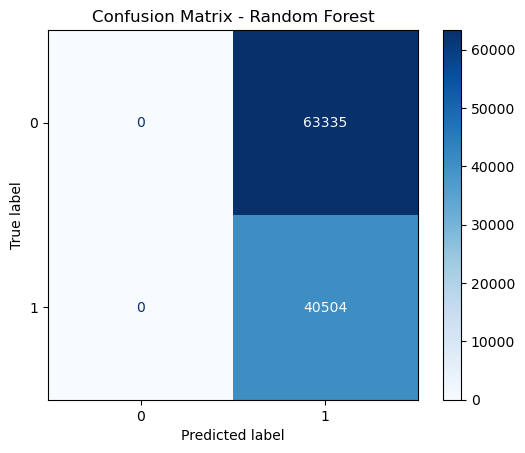

Accuracy of Gradient Boosting model is: 48.13% 

########################################################################
              precision    recall  f1-score   support

           0       0.15      0.99      0.26      9740
           1       1.00      0.43      0.60     94099

    accuracy                           0.48    103839
   macro avg       0.57      0.71      0.43    103839
weighted avg       0.92      0.48      0.57    103839

########################################################################
--- 10.635066747665405 seconds ---


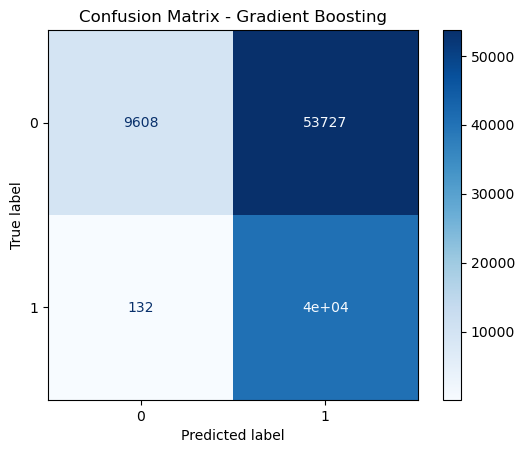

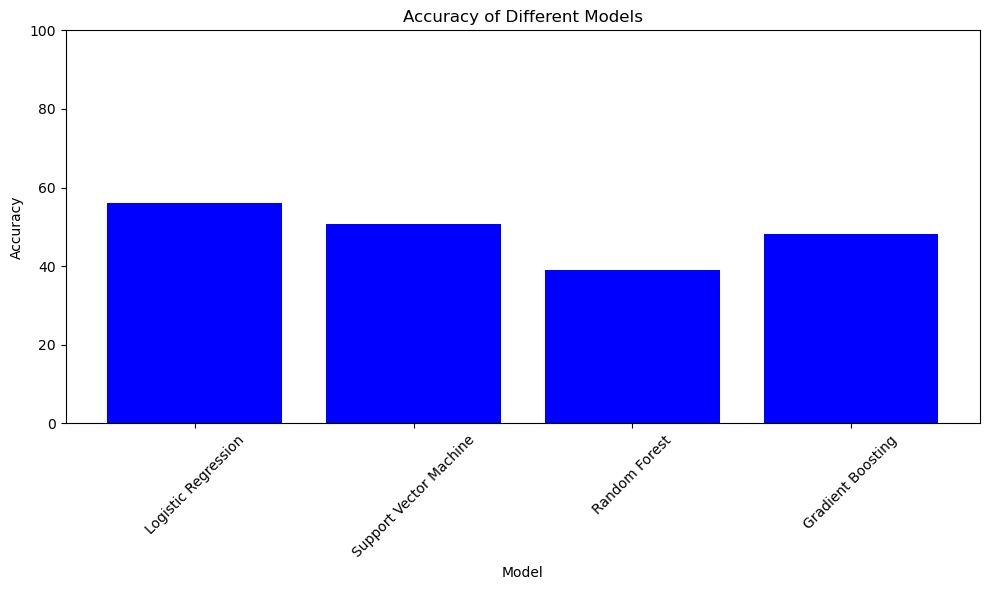

In [27]:
M.run_models()